### Test case LVV-T1842: Verify calculation of zeropoint error fraction exceeding the outlier limit

Verify that the DM system provides software to calculate the fraction of zeropoint errors that exceed the zero point error outlier limit, and confirm that it is less than **PF2 = 10 percent**.

### Test case LVV-T2202: Verify that the zero-point error outlier limit threshold (PA4) can be applied.

Verify that the DMS has provided the code to apply the zero-point error outlier limit threshold (PA4) to computed values of metrics. 

**Discussion**: We choose to verify this requirement by comparison of the calibrated photometry resulting from processing by the DM pipelines to the Monster reference catalog. For each visit, the median difference between the `source` table photometry and the reference catalog for high S/N stars is calculated. We will then take the ensemble of all measured median zeropoint offsets, and calculate the outlier fraction of the distribution to represent PF2, using the threshold PA4 to define what constitutes an outlier.

In [1]:
from astropy.table import Table
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

from lsst.daf.butler import Butler
from lsst.utils.plotting import get_multiband_plot_colors, get_multiband_plot_linestyles, get_multiband_plot_symbols

While the [TargetRefcatDeltaPhotomMetrics](https://github.com/lsst/analysis_tools/blob/e52006734b52f2011d899b2a94f549ff4b88daf7/python/lsst/analysis/tools/atools/refCatMatchPlots.py#L778-L855) task to calculate the offsets exists in `analysis_tools`, it is not part of the default pipelines. For this test, we ran the task on the LSSTCam data processed with w_2025_37 of the DRP pipeline. The results are retrieved from the relevant collection below.

In [2]:
testcoll = 'u/jcarlin/src_refmatch_atools_w37'
butler = Butler('/repo/main', collections=[testcoll])

#### Query the Butler for all datasets of type `source_ref_match_photom_metrics`:

In [3]:
srcref_refs = butler.query_datasets('source_ref_match_photom_metrics', collections=testcoll)

Extract the metrics to a table. Note that we take only the first element (i.e., the 0th index) of `photomDiffMetrics`, which is the median `source` - `refcat` offset.

Because this test concerns all bands *except* *u*-band, extract only the *grizy* results.

In [4]:
bands_list = ['g', 'r', 'i', 'z', 'y']
offsets = []
bands = []

for ref in srcref_refs:
    srcref_tmp = butler.get(ref)
    offsets.append(srcref_tmp['photomDiffMetrics'][0].quantity.value)
    bands.append(ref.dataId['band'])

tab = Table([offsets, bands], names=['offset', 'band'])

In [5]:
# Create a dict with indices of entries corresponding to each band:
band_sel_dict = {}

for band in bands_list:
    band_sel_dict[band] = (tab['band'] == band)

#### Plot histograms of the median `source`-`refcat` residuals:

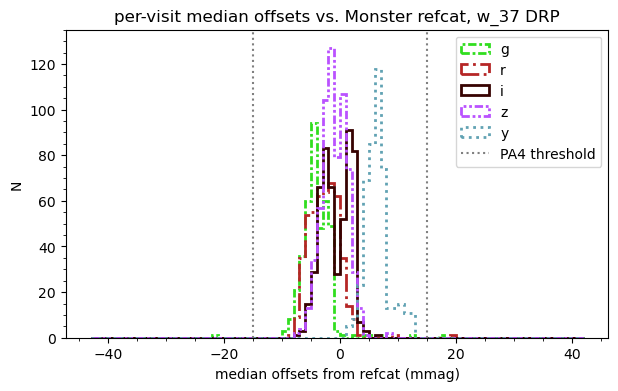

In [6]:
bandcolors = get_multiband_plot_colors()
bandlines = get_multiband_plot_linestyles()

fig = plt.figure(figsize=(7, 4))

for band in bands_list:
    plt.hist(tab['offset'][band_sel_dict[band]], bins=np.arange(-43, 43, 1.0), histtype='step',
             label=band, color=bandcolors[band], linestyle=bandlines[band],
             linewidth=2)

plt.vlines(-15, 0, 135, color='Gray', linestyle=':', label='PA4 threshold')
plt.vlines(15, 0, 135, color='Gray', linestyle=':', label='__none__')

plt.ylim(0, 135)
# plt.yscale('log')
plt.legend()
plt.minorticks_on()
plt.xlabel('median offsets from refcat (mmag)')
plt.ylabel('N')
plt.title('per-visit median offsets vs. Monster refcat, w_37 DRP')
plt.show()

#### Calculate statistics of the zeropoint offset distributions:

In [7]:
pa4_thresh = 15.0

for band in bands_list:
    offsets = tab['offset'][band_sel_dict[band]]
    outliers = np.where(offsets > pa4_thresh)
    outlier_pct = 100.0 * len(outliers[0])/len(offsets)
    print(f"\n{band} band:")
    print(f"PF2 (outlier percentage): {outlier_pct:7.2F} %")


g band:
PF2 (outlier percentage):    0.26 %

r band:
PF2 (outlier percentage):    0.21 %

i band:
PF2 (outlier percentage):    0.19 %

z band:
PF2 (outlier percentage):    0.00 %

y band:
PF2 (outlier percentage):    0.00 %


## Results

We have demonstrated that software tools exist to calculate zeropoint offsets, and that those residuals can be easily compiled for analysis. We see that very few of the zeropoint offsets between calibrated `source` tables and the reference catalog exceed the 15 mmag **PA4** threshold. Because the results for all five of the *grizy* bands are less than the specified threshold **PF2 = 10 %**, we deem the result of this test a **Pass**.